In [44]:
from keras.preprocessing import sequence  
from keras.models import Sequential  
from keras.datasets import boston_housing  
from keras.layers import Dense, Dropout, BatchNormalization
# from keras.utils import multi_gpu_model  
# from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model
from keras import regularizers  # 正则化  
import matplotlib.pyplot as plt  
import numpy as np
from sklearn.preprocessing import MinMaxScaler  
import pandas as pd

In [7]:
# 度量两点距离
import math
def rad(d):
    return d * math.pi / 180.0

# 地理坐标系：为球面坐标。 参考平面地是椭球面，坐标单位：经纬度；
# 投影坐标系：为平面坐标。参考平面地是水平面，坐标单位：米、千米等；
# 地理坐标转换到投影坐标的过程可理解为投影。（投影：将不规则的地球曲面转换为平面）

# 目前国内主要有三种地理坐标系
# 1、WGS84坐标系：即地球坐标系（World Geodetic System），国际上通用的坐标系。
# 设备包含的GPS芯片或者北斗芯片获取的经纬度一般都是为WGS84地理坐标系，目前谷歌地图采用的是WGS84坐标系（中国范围除外）。
# 2、GCJ02坐标系：即火星坐标系，国测局坐标系。是由中国国家测绘局制定。由WGS84坐标系经加密后的坐标系。谷歌中国和搜搜中国采用。
# 3、BD09坐标系：百度坐标系，GCJ02坐标系经加密后的坐标系。

# 投影：墨卡托投影、高斯-克吕格 (Gauss-Krüger) 投影
# 感兴趣的同学可以在https://desktop.arcgis.com/zh-cn/arcmap/10.3/guide-books/map-projections/list-of-supported-map-projections.htm深入了解

# gps两点间距离（单位为米）
def distance(true_pt, pred_pt):
    lat1 = float(true_pt[1])
    lng1 = float(true_pt[0])
    lat2 = float(pred_pt[1])
    lng2 = float(pred_pt[0])
    radLat1 = rad(lat1)
    radLat2 = rad(lat2)
    a = radLat1 - radLat2
    b = rad(lng1) - rad(lng2)
    s = 2 * math.asin(math.sqrt(math.pow(math.sin(a/2),2) +
    math.cos(radLat1)*math.cos(radLat2)*math.pow(math.sin(b/2),2)))
    s = s * 6378.137
    s = round(s * 10000) / 10
    return s

In [2]:
from sklearn.utils import shuffle  

# 加载数据集
def load_data(data_path, shuff=True):
    data = pd.read_csv(data_path)
    data = data.fillna(-1)  # Nan值填充
#     print(data.iloc[1000])
    if shuff:   # 将数据集打乱
        data = shuffle(data)
#     print(data.iloc[1000])
    # 构建数据集和标签
    samples = []
    labels = []
    for index, row in data.iterrows():
    # print(row) # 输出每行的索引值
        matrix = []  # 7 * 4
        for i in range(7):
            matrix.append([i+1,
                           row['AsuLevel_' + str(i+1)],
                           row['SignalLevel_' + str(i+1)],
                           row['Dbm_' + str(i+1)]]) # 新数据集中不存在RSSI，使用Dbm(代功率的绝对值)
        # print(matrix)
        samples.append(matrix)
        labels.append([row['Longitude'], row['Latitude']])
    return np.array(samples), np.array(labels)

In [3]:
path = r"./siping_4g.csv"
samples, labels = load_data(path)
print(samples[0], labels[0])

[[   1.   63.    4.  -77.]
 [   2.   59.    4.  -81.]
 [   3.   53.    4.  -87.]
 [   4.   31.    2. -109.]
 [   5.   27.    2. -113.]
 [   6.   12.    1. -128.]
 [   7.   22.    1. -118.]] [121.4994009   31.28594976]


In [4]:
print(samples.shape)
print(labels.shape)
# 数据变形： (3479, 7, 4)---》 (3479, 7, 4，1)
# samples = samples.reshape(-1, 7,4,1) # -1自动计算
samples = samples.reshape(samples.shape[0], -1)
print(samples.shape)

(3479, 7, 4)
(3479, 2)


In [20]:
# from sklearn.model_selection import train_test_split

# # 划分数据集
# x_train, x_valid, y_train, y_valid = train_test_split(samples, labels, test_size=0.2)  #划分训练数据、训练标签、验证数据、验证标签

# # 训练集归一化  
# min_max_scaler = MinMaxScaler()  
# min_max_scaler.fit(x_train)  
# x_train = min_max_scaler.transform(x_train)  

# min_max_scaler.fit(y_train)  
# y_train = min_max_scaler.transform(y_train)  
  
# # 验证集归一化  
# min_max_scaler.fit(x_valid)  
# x_valid = min_max_scaler.transform(x_valid)  

# min_max_scaler.fit(y_valid)  
# y_valid = min_max_scaler.transform(y_valid)
# x_train=x_train.reshape(-1,7,4)
# y_train=y_train.reshape(-1,2)
# x_valid=x_valid.reshape(-1,7,4)
# y_valid=y_valid.reshape(-1,2)

# print(x_train.shape)
# print(y_train.shape)
# print(x_valid.shape)
# print(y_valid.shape)

from sklearn.model_selection import train_test_split

# 划分数据集
x_train, x_valid, y_train, y_valid = train_test_split(samples, labels, test_size=0.2)  #划分训练数据、训练标签、验证数据、验证标签
# 转成DataFrame格式方便数据处理
x_train_pd = pd.DataFrame(x_train)  
y_train_pd = pd.DataFrame(y_train)  
x_valid_pd = pd.DataFrame(x_valid)  
y_valid_pd = pd.DataFrame(y_valid)  
# print(x_train_pd.head(5)) 
# print('-------------------') 
# print(y_train_pd.head(5))

# 训练集归一化  
min_max_scaler = MinMaxScaler()  
min_max_scaler.fit(x_train_pd)  
x_train = min_max_scaler.transform(x_train_pd)  

min_max_scaler.fit(y_train_pd)  
y_train = min_max_scaler.transform(y_train_pd)  
  
# 验证集归一化  
min_max_scaler.fit(x_valid_pd)  
x_valid = min_max_scaler.transform(x_valid_pd)  

min_max_scaler.fit(y_valid_pd)  
y_valid = min_max_scaler.transform(y_valid_pd)

x_train=x_train.reshape(-1,7,4)
y_train=y_train.reshape(-1,2)
x_valid=x_valid.reshape(-1,7,4)
y_valid=y_valid.reshape(-1,2)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(2783, 7, 4)
(2783, 2)
(696, 7, 4)
(696, 2)


In [110]:
# 单CPU or GPU版本，若有GPU则自动切换
from keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten, Dropout
model = Sequential()  # 初始化，很重要！
model.add(Convolution2D(input_shape=(7, 4, 1),
          filters=64,
          kernel_size=3,
          strides=1,
          padding='same',
          activation='relu'))

# 池化层  14*14
model.add(MaxPooling2D(2, 2, 'same'))

model.add(Convolution2D(
          filters=32,
          kernel_size=3,
          strides=1,
          padding='same',
          activation='relu'))

model.add(MaxPooling2D(1, 1, 'same'))

# 把池化层的输出扁平化为一维   7*7
model.add(Flatten())
model.add(Dropout(0.4))  # 丢弃神经元链接概率
# model.add(BatchNormalization()) # （批）规范化层

model.add(Dense(units=10,   # 输出大小
                activity_regularizer=regularizers.l1(0.01),  # 施加在输出上的正则项
                activation='relu',  # 激励函数
                bias_regularizer=regularizers.l1_l2(0.01)  # 施加在偏置向量上的正则项
                )
          )

model.add(Dropout(0.3))  # 丢弃神经元链接概率

model.add(Dense(units=15,
                #                 kernel_regularizer=regularizers.l2(0.01),  # 施加在权重上的正则项
                activity_regularizer=regularizers.l1(0.01),  # 施加在输出上的正则项
                activation='relu',  # 激励函数
                bias_regularizer=regularizers.l1_l2(0.01)  # 施加在偏置向量上的正则项
                )
          )

#######
model.add(Dense(units=28, activation='relu'))
model.add(Dropout(0.4))  # 丢弃神经元链接概率
model.add(Dense(units=15, activation='relu'))

#######

model.add(Dense(units=2,
                activation='linear'  # 线性激励函数 回归一般在输出层用这个激励函数
                )
          )

print(model.summary())  # 打印网络层次结构

model.compile(loss='mae',  
              optimizer='adam', 
              metrics=['mae']
              )


history = model.fit(x_train, y_train,
                    epochs=400, 
                    batch_size=200, 
                    verbose=2, 
                    validation_data=(x_valid, y_valid) 
                    )

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 7, 4, 64)          640       
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 4, 2, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 4, 2, 32)          18464     
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 4, 2, 32)         0         
 g2D)                                                            
                                                                 
 flatten_21 (Flatten)        (None, 256)               0         
                                                                 
 dropout_62 (Dropout)        (None, 256)             

Epoch 53/400
14/14 - 0s - loss: 0.2180 - mae: 0.2152 - val_loss: 0.2240 - val_mae: 0.2216 - 100ms/epoch - 7ms/step
Epoch 54/400
14/14 - 0s - loss: 0.2171 - mae: 0.2142 - val_loss: 0.2184 - val_mae: 0.2155 - 99ms/epoch - 7ms/step
Epoch 55/400
14/14 - 0s - loss: 0.2162 - mae: 0.2131 - val_loss: 0.2220 - val_mae: 0.2197 - 99ms/epoch - 7ms/step
Epoch 56/400
14/14 - 0s - loss: 0.2163 - mae: 0.2134 - val_loss: 0.2211 - val_mae: 0.2184 - 104ms/epoch - 7ms/step
Epoch 57/400
14/14 - 0s - loss: 0.2183 - mae: 0.2151 - val_loss: 0.2179 - val_mae: 0.2149 - 100ms/epoch - 7ms/step
Epoch 58/400
14/14 - 0s - loss: 0.2172 - mae: 0.2142 - val_loss: 0.2172 - val_mae: 0.2142 - 107ms/epoch - 8ms/step
Epoch 59/400
14/14 - 0s - loss: 0.2149 - mae: 0.2116 - val_loss: 0.2218 - val_mae: 0.2192 - 99ms/epoch - 7ms/step
Epoch 60/400
14/14 - 0s - loss: 0.2143 - mae: 0.2113 - val_loss: 0.2190 - val_mae: 0.2163 - 108ms/epoch - 8ms/step
Epoch 61/400
14/14 - 0s - loss: 0.2135 - mae: 0.2104 - val_loss: 0.2161 - val_mae: 

14/14 - 0s - loss: 0.1991 - mae: 0.1965 - val_loss: 0.2075 - val_mae: 0.2053 - 110ms/epoch - 8ms/step
Epoch 125/400
14/14 - 0s - loss: 0.1987 - mae: 0.1963 - val_loss: 0.2046 - val_mae: 0.2026 - 103ms/epoch - 7ms/step
Epoch 126/400
14/14 - 0s - loss: 0.1983 - mae: 0.1958 - val_loss: 0.2043 - val_mae: 0.2021 - 104ms/epoch - 7ms/step
Epoch 127/400
14/14 - 0s - loss: 0.1993 - mae: 0.1968 - val_loss: 0.2071 - val_mae: 0.2049 - 106ms/epoch - 8ms/step
Epoch 128/400
14/14 - 0s - loss: 0.1980 - mae: 0.1956 - val_loss: 0.2021 - val_mae: 0.1999 - 99ms/epoch - 7ms/step
Epoch 129/400
14/14 - 0s - loss: 0.1974 - mae: 0.1949 - val_loss: 0.2060 - val_mae: 0.2039 - 100ms/epoch - 7ms/step
Epoch 130/400
14/14 - 0s - loss: 0.1963 - mae: 0.1938 - val_loss: 0.2054 - val_mae: 0.2033 - 104ms/epoch - 7ms/step
Epoch 131/400
14/14 - 0s - loss: 0.1974 - mae: 0.1948 - val_loss: 0.2041 - val_mae: 0.2017 - 106ms/epoch - 8ms/step
Epoch 132/400
14/14 - 0s - loss: 0.1976 - mae: 0.1949 - val_loss: 0.2040 - val_mae: 0.2

Epoch 195/400
14/14 - 0s - loss: 0.1915 - mae: 0.1888 - val_loss: 0.2004 - val_mae: 0.1982 - 106ms/epoch - 8ms/step
Epoch 196/400
14/14 - 0s - loss: 0.1882 - mae: 0.1856 - val_loss: 0.2017 - val_mae: 0.1994 - 102ms/epoch - 7ms/step
Epoch 197/400
14/14 - 0s - loss: 0.1887 - mae: 0.1862 - val_loss: 0.1965 - val_mae: 0.1942 - 105ms/epoch - 7ms/step
Epoch 198/400
14/14 - 0s - loss: 0.1894 - mae: 0.1868 - val_loss: 0.1982 - val_mae: 0.1958 - 104ms/epoch - 7ms/step
Epoch 199/400
14/14 - 0s - loss: 0.1912 - mae: 0.1885 - val_loss: 0.2001 - val_mae: 0.1976 - 102ms/epoch - 7ms/step
Epoch 200/400
14/14 - 0s - loss: 0.1885 - mae: 0.1860 - val_loss: 0.1954 - val_mae: 0.1932 - 101ms/epoch - 7ms/step
Epoch 201/400
14/14 - 0s - loss: 0.1895 - mae: 0.1870 - val_loss: 0.1969 - val_mae: 0.1946 - 105ms/epoch - 8ms/step
Epoch 202/400
14/14 - 0s - loss: 0.1872 - mae: 0.1845 - val_loss: 0.1971 - val_mae: 0.1945 - 105ms/epoch - 7ms/step
Epoch 203/400
14/14 - 0s - loss: 0.1898 - mae: 0.1870 - val_loss: 0.2026

Epoch 266/400
14/14 - 0s - loss: 0.1825 - mae: 0.1801 - val_loss: 0.1933 - val_mae: 0.1912 - 103ms/epoch - 7ms/step
Epoch 267/400
14/14 - 0s - loss: 0.1848 - mae: 0.1825 - val_loss: 0.1970 - val_mae: 0.1948 - 102ms/epoch - 7ms/step
Epoch 268/400
14/14 - 0s - loss: 0.1823 - mae: 0.1800 - val_loss: 0.1940 - val_mae: 0.1919 - 100ms/epoch - 7ms/step
Epoch 269/400
14/14 - 0s - loss: 0.1830 - mae: 0.1805 - val_loss: 0.1962 - val_mae: 0.1939 - 101ms/epoch - 7ms/step
Epoch 270/400
14/14 - 0s - loss: 0.1821 - mae: 0.1797 - val_loss: 0.1963 - val_mae: 0.1940 - 99ms/epoch - 7ms/step
Epoch 271/400
14/14 - 0s - loss: 0.1833 - mae: 0.1808 - val_loss: 0.1961 - val_mae: 0.1940 - 103ms/epoch - 7ms/step
Epoch 272/400
14/14 - 0s - loss: 0.1837 - mae: 0.1812 - val_loss: 0.1938 - val_mae: 0.1916 - 104ms/epoch - 7ms/step
Epoch 273/400
14/14 - 0s - loss: 0.1832 - mae: 0.1807 - val_loss: 0.1950 - val_mae: 0.1928 - 100ms/epoch - 7ms/step
Epoch 274/400
14/14 - 0s - loss: 0.1838 - mae: 0.1814 - val_loss: 0.1981 

Epoch 337/400
14/14 - 0s - loss: 0.1804 - mae: 0.1778 - val_loss: 0.1953 - val_mae: 0.1930 - 106ms/epoch - 8ms/step
Epoch 338/400
14/14 - 0s - loss: 0.1798 - mae: 0.1773 - val_loss: 0.1957 - val_mae: 0.1936 - 103ms/epoch - 7ms/step
Epoch 339/400
14/14 - 0s - loss: 0.1795 - mae: 0.1773 - val_loss: 0.1947 - val_mae: 0.1926 - 102ms/epoch - 7ms/step
Epoch 340/400
14/14 - 0s - loss: 0.1833 - mae: 0.1808 - val_loss: 0.1928 - val_mae: 0.1907 - 102ms/epoch - 7ms/step
Epoch 341/400
14/14 - 0s - loss: 0.1825 - mae: 0.1800 - val_loss: 0.1957 - val_mae: 0.1933 - 100ms/epoch - 7ms/step
Epoch 342/400
14/14 - 0s - loss: 0.1834 - mae: 0.1806 - val_loss: 0.1986 - val_mae: 0.1963 - 100ms/epoch - 7ms/step
Epoch 343/400
14/14 - 0s - loss: 0.1807 - mae: 0.1781 - val_loss: 0.1929 - val_mae: 0.1907 - 98ms/epoch - 7ms/step
Epoch 344/400
14/14 - 0s - loss: 0.1826 - mae: 0.1801 - val_loss: 0.1934 - val_mae: 0.1913 - 99ms/epoch - 7ms/step
Epoch 345/400
14/14 - 0s - loss: 0.1802 - mae: 0.1778 - val_loss: 0.1949 -

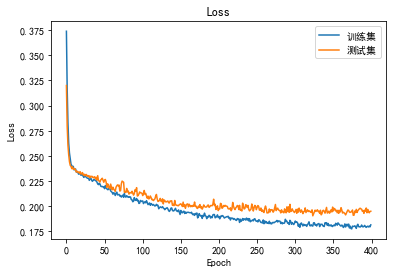

In [111]:
import matplotlib.pyplot as plt 
# 绘制训练 & 验证的损失值  
from pylab import mpl # 设置显示中文字体 
mpl.rcParams["font.sans-serif"] = ["SimHei"]
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['训练集', '测试集'], loc='best')  
plt.show()

In [112]:
# 预测
y_new = model.predict(x_valid)  
# 反归一化还原原始量纲  
min_max_scaler.fit(y_valid_pd) 
y_new = min_max_scaler.inverse_transform(y_new) 

err = [distance(p,t) for p, t in zip(y_valid_pd.values, y_new)]
print('平均绝对误差 MAE : ', '%.4f'% np.mean(np.abs(err)))
print('均方误差 MSE : ', '%.4f'% np.mean(np.square(err)))
percentage_err = np.abs(err - np.mean(err)) / np.mean(err)
print('平均绝对百分比误差 MAPE : ', '%.4f'% np.mean(percentage_err))
print('绝对误差中位数 MedAE : ', '%.4f'% np.median(err))

22/22 [==============================] - 0s 950us/step
平均绝对误差 MAE :  221.7894
均方误差 MSE :  82183.3085
平均绝对百分比误差 MAPE :  0.6586
绝对误差中位数 MedAE :  186.7000


In [113]:
# 预测
y_new = model.predict(x_train)  
# 反归一化还原原始量纲  
min_max_scaler.fit(y_train_pd) 
y_new = min_max_scaler.inverse_transform(y_new) 

err = [distance(p,t) for p, t in zip(y_train_pd.values, y_new)]
print('平均绝对误差 MAE : ', '%.4f'% np.mean(np.abs(err)))
print('均方误差 MSE : ', '%.4f'% np.mean(np.square(err)))
percentage_err = np.abs(err - np.mean(err)) / np.mean(err)
print('平均绝对百分比误差 MAPE : ', '%.4f'% np.mean(percentage_err))
print('绝对误差中位数 MedAE : ', '%.4f'% np.median(err))

87/87 [==============================] - 0s 905us/step
平均绝对误差 MAE :  197.0024
均方误差 MSE :  67699.3086
平均绝对百分比误差 MAPE :  0.6746
绝对误差中位数 MedAE :  171.8000


In [ ]:
for i in range(len(y_new)):
    print(y_valid_pd.values[i], y_new[i])